In [1]:
import numpy as np 
import pandas as pd
import os
from Dataset.Utils import prepare_data, read_fasta
# from Dataset.Resample import resample

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define data paths
data_paths = {
    'knn_terms_df':         '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/diamond_knn_predictions.parquet',
    'train_terms_df':       '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_terms.tsv',
    'go_obo_path':          '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/go-basic.obo',
    "features_embeds_path": "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_embeddings.npy",
    "features_ids_path":    "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_ids.npy",
    'go_embeds_paths':      '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/go_embeddings.pkl'
}

print("Data paths configured")

Data paths configured


In [3]:
data = prepare_data(data_paths)

Padding terms_predicted with GO graph neighbors...
Padding complete. Average terms per row: 238.95


In [4]:
label_freq = data['train_terms'].groupby('term').agg(entries= ('EntryID', 'count')).sort_values('entries', ascending=False)
label_freq.head()

,entries
term,
GO:0005515,33713
GO:0005634,13283
GO:0005829,13040
GO:0005886,10150
GO:0005737,9442


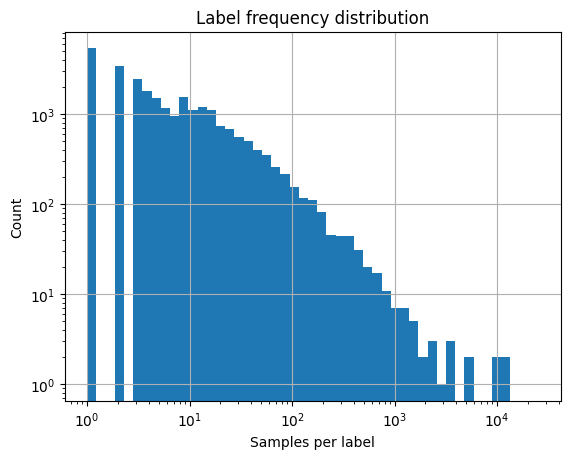

In [10]:
label_freq = data['train_terms'].groupby('term').agg(entries= ('EntryID', 'count')).sort_values('entries', ascending=False)


#create log bins 
bins = np.logspace(0, 4.4, num=50)  # Bins from 1 to ~25000

plt.hist(label_freq['entries'], bins=bins)
plt.yscale('log') 
plt.xscale('log')
plt.title('Label frequency distribution')
plt.xlabel('Samples per label')
plt.ylabel('Count')
# plt.xlim((0,1000))
plt.grid(True)
plt.show()

In [12]:
#for given thresholds, how many labels are there with samples <= threshold add percentage too
thresholds = [1, 2, 5, 10, 50, 100, 1000, 10000]
for t in thresholds:
    count = (label_freq['entries'] <= t).sum()
    pct = (count / len(label_freq)) * 100
    print(f"Labels with at most {t} samples: \t {count} ({pct:.2f}%)")


Labels with at most 1 samples: 	 5377 (20.58%)
Labels with at most 2 samples: 	 8817 (33.75%)
Labels with at most 5 samples: 	 14584 (55.82%)
Labels with at most 10 samples: 	 18868 (72.22%)
Labels with at most 50 samples: 	 24583 (94.10%)
Labels with at most 100 samples: 	 25462 (97.46%)
Labels with at most 1000 samples: 	 26092 (99.87%)
Labels with at most 10000 samples: 	 26121 (99.98%)


Label distribution by category:
category
ones                     5377
rare (1-5)               9207
uncommon (6-10)          4284
common (10-100)          6594
frequent (100-1000)       630
very frequent (1000+)      33
Name: count, dtype: int64

Co-occurrence correlation matrix (Jaccard similarity):
                       very frequent (1000+)  frequent (100-1000)  \
very frequent (1000+)                 1.0000               0.5302   
frequent (100-1000)                   0.5302               1.0000   
common (10-100)                       0.5297               0.5634   
uncommon (6-10)                       0.2462               0.2758   
rare (1-5)                            0.2156               0.2396   
ones                                  0.0539               0.0611   

                       common (10-100)  uncommon (6-10)  rare (1-5)    ones  
very frequent (1000+)           0.5297           0.2462      0.2156  0.0539  
frequent (100-1000)             0.5634           0.2758  

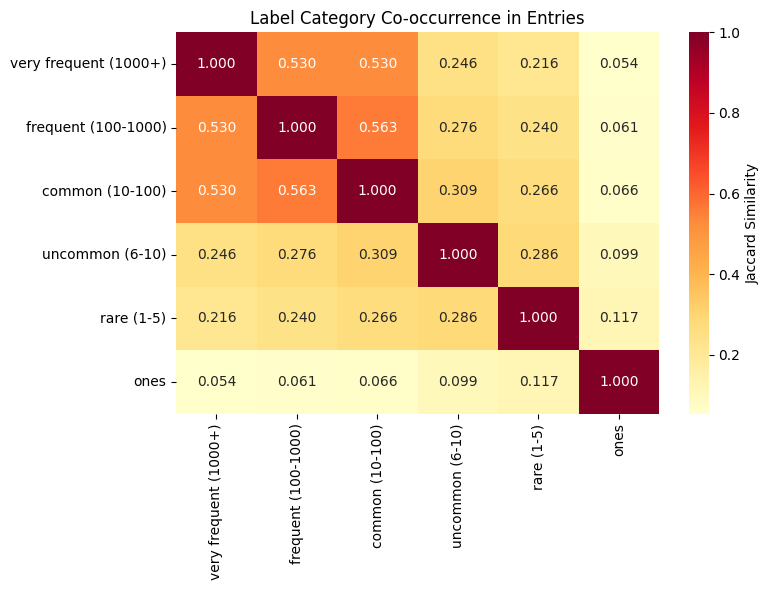

In [14]:
from itertools import combinations

# Categorize labels based on frequency
def categorize_labels(freq_df):
    categories = pd.cut(freq_df['entries'], 
                       bins=[0, 1, 5, 10, 100, 1000, float('inf')],
                       labels=['ones', 'rare (1-5)', 'uncommon (6-10)', 'common (10-100)', 'frequent (100-1000)', 'very frequent (1000+)'])
    return categories

label_freq['category'] = categorize_labels(label_freq)

# Display category distribution
print("Label distribution by category:")
print(label_freq['category'].value_counts().sort_index())
print()

# Create a binary matrix for co-occurrence analysis
# Get terms for each category
categories_dict = {}
for cat in label_freq['category'].unique():
    categories_dict[cat] = label_freq[label_freq['category'] == cat].index.tolist()

# Calculate co-occurrence between categories

co_occurrence = pd.DataFrame(index=label_freq['category'].unique(), 
                             columns=label_freq['category'].unique(), 
                             dtype=float)

for cat1, cat2 in combinations(categories_dict.keys(), 2):
    # Get entries that have at least one term from each category
    terms1 = categories_dict[cat1]
    terms2 = categories_dict[cat2]
    
    entries_with_cat1 = set(data['train_terms'][data['train_terms']['term'].isin(terms1)]['EntryID'])
    entries_with_cat2 = set(data['train_terms'][data['train_terms']['term'].isin(terms2)]['EntryID'])
    
    # Co-occurrence: entries having both categories
    co_occur = len(entries_with_cat1 & entries_with_cat2)
    
    # Normalize by the smaller set size (Jaccard-like metric)
    jaccard = co_occur / len(entries_with_cat1 | entries_with_cat2) if len(entries_with_cat1 | entries_with_cat2) > 0 else 0
    
    co_occurrence.loc[cat1, cat2] = jaccard
    co_occurrence.loc[cat2, cat1] = jaccard

# Fill diagonal with 1.0
for cat in co_occurrence.index:
    co_occurrence.loc[cat, cat] = 1.0

print("Co-occurrence correlation matrix (Jaccard similarity):")
print(co_occurrence.astype(float).round(4))
print()

# Visualize the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence.astype(float), annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Jaccard Similarity'})
plt.title('Label Category Co-occurrence in Entries')
plt.tight_layout()
plt.show()